In [16]:
#GPUを用いて、pytorchを使ったViTモデルを作成する
import pandas as pd
# import tensorflow as tf
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm
import torch

#データの読み込み
mat_file = 'mat/60_sin_1period_bpsk_long_2signal.mat'
data = scipy.io.loadmat(mat_file)

#matファイルの中身の変数名を確認する

data.keys()
a = data['R_xx']
# a = data['R_xx_exist_Noise']
b = data['inputVec']
c = data['label']

sigmax2=data['sigmaX2']

t=data['t']
# print(t)
#matに保存した変数の呼び出し
#a,b,cの次元数を確認する
print(a.shape)
print(b.shape)
print(c.shape)

#共分散行列
R = a
label=c

loop=5

for i in range(loop-1):
    R=np.concatenate((R,a),axis=2)
    label=np.concatenate((label,c),axis=0)

print(R.shape)
print(label.shape)

(10, 10, 10000)
(10000, 101)
(10000, 2)
(10, 10, 50000)
(50000, 2)


In [17]:
# #入力信号の電力
# sigmax2=d
# #スナップショット数
# t=e

#実数部と虚数部(虚数単位jは外す)に分ける関数
def split_complex(x):
    real = np.real(x)
    imag = np.imag(x)
    return real, imag


#実数部と虚数部に分ける
real, imag = split_complex(R)

#実数部と虚数部の次元数を確認する
print(real.shape)
print(imag.shape)

#実数部と虚数部を結合し、四次元配列に変換する
R = np.stack([real, imag], axis=3)

#Rの次元数を確認する
print(R.shape)

#Rはx(t)=As(t)+n(t)という信号モデルの共分散行列(Rはx(t)の複素共役転置の期待値)である（Aは方向行列、s(t)は入力信号、n(t)はガウス雑音）
#Rには、本来Aとs(t)とn(t)の情報が含まれているが、今回はn(t)を含まない
#Rにn(t)を乗せる処理を書く

#SNRを定義する
SNR=np.empty((1,1))
np.append(SNR,30)

#送信電力とSNRから雑音電力を求める
#送信電力は、sigmaX2である
#雑音電力は、sigmaN2である
def calculate_noise_covariance(sigmaX2, SNR, t, R):
    # 送信電力から雑音電力を計算する
    sigman2 = np.divide(sigmaX2, (10**(SNR/10)))

    # sigmaN2を表示する
    # print(sigman2)

    # ガウス分布に従う雑音n(t)を生成する
    noise = np.sqrt(sigman2/2) * (np.random.randn(len(t),len(R[:,0,0,0])) + 1j*np.random.randn(len(t),len(R[:,0,0,0])))

    # n(t)の次元数を確認する
    # print(noise.shape)

    # n(t)の共分散行列を求める
    N = np.dot(np.conj(noise).T, noise)

    # Nの次元数を確認する
    # print("R_n", N.shape)

    # Nの実部と虚部を分割する
    real, imag = np.real(N), np.imag(N)

    # Nを結合して次元数を確認する
    N = np.stack([real, imag], axis=2)
    # print("R_n", N.shape)

    return N

for j in range(len(SNR)):

    # 繰り返し回数と結果を格納するリストの定義
    num_iterations = R.shape[2]
    N = []

    # 繰り返し処理
    for _ in range(num_iterations):
        # 関数の呼び出しと結果の取得
        result = calculate_noise_covariance(sigmax2, SNR, t, R)
        N.append(result)

    N=np.array(N)
    # 結果の出力
    # for i, result in enumerate(results):
    #     print(f"Result {i+1}:\n{result}\n")


    #Nの次元数を確認する
    # print("R", R.shape)
    # print("N", N.shape)

    #Nの0番目と2番目の次元数を入れ替える
    N = np.swapaxes(N, 0, 2)
    # print(N.shape)


    #RにNを足す
    R = R + N
    # print('R.shape',R.shape)

X = R
Y = label



print(X.shape)
#Xを3次元配列に変換する
X = np.reshape(X, (X.shape[2], X.shape[0], X.shape[1], X.shape[3]))

print(X.shape)

from sklearn.model_selection import train_test_split

#学習データセットと検証データセットとテストデータセットの分割割合を変数で指定する
train_size = 0.8
val_size = 0.1
test_size = 0.1

#学習データセットと検証データセットとテストデータセットを分割する(シャッフルはしない)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=1 - train_size, shuffle=False)
XVal, XTest, YVal, YTest = train_test_split(XTest, YTest, test_size=test_size / (test_size + val_size), shuffle=False)

#学習データセットと検証データセットとテストデータセットの次元数を確認する
print(XTrain.shape)
print(XVal.shape)
print(XTest.shape)
print(YTrain.shape)
print(YVal.shape)
print(YTest.shape)

#入力の次元はそれぞれ(サンプル数、タイムステップ数、特徴量)である
# Xの2番目の次元と3番目の次元を入れ替える
XTrain = np.swapaxes(XTrain, 1, 3)
XVal = np.swapaxes(XVal, 1, 3)
XTest = np.swapaxes(XTest, 1, 3)


#学習データセットと検証データセットとテストデータセットの次元数を確認する
print("----------------")
print("XTrain",XTrain.shape)
print("XVal",XVal.shape)
print("XTest",XTest.shape)
print("YTrain",YTrain.shape)
print("YVal",YVal.shape)
print("YTest",YTest.shape)


(10, 10, 50000)
(10, 10, 50000)
(10, 10, 50000, 2)
(10, 10, 50000, 2)
(50000, 10, 10, 2)
(40000, 10, 10, 2)
(5000, 10, 10, 2)
(5000, 10, 10, 2)
(40000, 2)
(5000, 2)
(5000, 2)
----------------
XTrain (40000, 2, 10, 10)
XVal (5000, 2, 10, 10)
XTest (5000, 2, 10, 10)
YTrain (40000, 2)
YVal (5000, 2)
YTest (5000, 2)


In [18]:
from sklearn.model_selection import train_test_split

#学習データセットと検証データセットとテストデータセットの分割割合を変数で指定する
# train_size = 0.8
# val_size = 0.1
# test_size = 0.1
# 
# #学習データセットと検証データセットとテストデータセットを分割する(シャッフルはしない)
# XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=1 - train_size, shuffle=False)
# XVal, XTest, YVal, YTest = train_test_split(XTest, YTest, test_size=test_size / (test_size + val_size), shuffle=False)
# 
# #学習データセットと検証データセットとテストデータセットの次元数を確認する
# print(XTrain.shape)
# print(XVal.shape)
# print(XTest.shape)
# print(YTrain.shape)
# print(YVal.shape)
# print(YTest.shape)




In [19]:
from torch.utils.data import DataLoader
#pytorchでのCNN回帰の実装
import torch


XTrain=torch.FloatTensor(XTrain)
XVal=torch.FloatTensor(XVal)
XTest=torch.FloatTensor(XTest)
YTrain=torch.FloatTensor(YTrain)
YVal=torch.FloatTensor(YVal)
YTest=torch.FloatTensor(YTest)

Dataset_train = torch.utils.data.TensorDataset(XTrain, YTrain)
Dataset_val = torch.utils.data.TensorDataset(XVal, YVal)
Dataset_test = torch.utils.data.TensorDataset(XTest, YTest)

X_sample, y_sample = Dataset_train[0]
print(X_sample, y_sample)
batch_size = 256
train_loader = DataLoader(dataset = Dataset_train, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = Dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = Dataset_train, batch_size=batch_size, shuffle=False)

tensor([[[233.5321, 199.0856, 185.5520, 187.7318, 197.7368, 203.0217, 201.3712,
          205.9053, 206.2003, 215.0743],
         [201.4374, 224.6504, 221.6845, 204.7339, 202.0521, 190.1966, 208.2417,
          197.2550, 222.3541, 187.8112],
         [222.9529, 200.9756, 200.9525, 201.9466, 220.9249, 203.1828, 191.7723,
          206.2192, 190.9809, 215.5288],
         [222.2750, 219.6235, 208.6585, 198.6640, 195.7222, 194.9901, 209.2837,
          202.8367, 202.5906, 216.7395],
         [189.9903, 211.3389, 190.3188, 199.5608, 203.1017, 212.2403, 189.3137,
          198.7931, 197.0494, 205.9131],
         [209.0708, 220.1225, 224.6394, 195.9969, 204.0175, 193.0838, 191.2702,
          197.0010, 199.8100, 194.3402],
         [195.6081, 209.0483, 218.0102, 178.5329, 224.6121, 184.5243, 191.2879,
          218.3941, 188.2168, 181.5977],
         [217.8104, 194.8178, 187.5014, 193.3494, 202.3380, 207.2486, 183.8153,
          199.7572, 171.0480, 217.2756],
         [200.9974, 195.7763, 17

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#CNNのモデルを作成する
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [21]:
# import torch.nn as nn
class Block(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        channel = channel_out // 4
        # 1x1 の畳み込み
        self.conv1 = nn.Conv2d(channel_in, channel,
                               kernel_size=(1, 1))
        self.bn1 = nn.BatchNorm2d(channel)
        self.relu1 = nn.ReLU()
        # 3x3 の畳み込み
        self.conv2 = nn.Conv2d(channel, channel,
                               kernel_size=(3, 3),
                               padding=1)
        self.bn2 = nn.BatchNorm2d(channel)
        self.relu2 = nn.ReLU()
        # 1x1 の畳み込み
        self.conv3 = nn.Conv2d(channel, channel_out,
                               kernel_size=(1, 1),
                               padding=0)
        self.bn3 = nn.BatchNorm2d(channel_out)
        # skip connection用のチャネル数調整        
        self.shortcut = self._shortcut(channel_in, channel_out)
        
        self.relu3 = nn.ReLU()
    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        y = self.relu3(h + shortcut)  # skip connection
        return y
    def _shortcut(self, channel_in, channel_out):
        if channel_in != channel_out:
            return self._projection(channel_in, channel_out)
        else:
            return lambda x: x
    def _projection(self, channel_in, channel_out):
        return nn.Conv2d(channel_in, channel_out,
                         kernel_size=(1, 1),
                         padding=0)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2,padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1)
        
        
        self.fc1 = nn.Linear(in_features=128*10*10, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.relu(self.conv2(x))
        # print(x.shape)
        x = F.relu(self.conv3(x))
        # print(x.shape)
        # x = self.pool(x)
        # print(x.shape)
        x = F.relu(self.conv4(x))
        # print(x.shape))
        x = x.view(-1, 128*10*10)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        x = self.fc3(x)
        # print(x.shape)
        x = self.fc4(x)
        # print(x.shape)
        
        return x
    
    
net = nn.Sequential(
    nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(),
    # self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2,padding=1)
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(),
    nn.Linear(in_features=128*10*10, out_features=256),
    nn.Linear(in_features=256, out_features=128),
    nn.Linear(in_features=128, out_features=64),
    #dropout
    nn.Dropout(0.5),
    nn.Linear(in_features=64, out_features=2)
)

net = Net().to(device)

# print(net)

In [23]:
import torchvision.models as models
from torchinfo import summary

batch_size = 256
summary(model=net, input_size=(batch_size, 2, 10, 10))


# print((data[0].to(device)).shape)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [256, 2]                  --
├─Conv2d: 1-1                            [256, 16, 10, 10]         304
├─Conv2d: 1-2                            [256, 32, 10, 10]         4,640
├─Conv2d: 1-3                            [256, 64, 10, 10]         18,496
├─Conv2d: 1-4                            [256, 128, 10, 10]        73,856
├─Linear: 1-5                            [256, 256]                3,277,056
├─Linear: 1-6                            [256, 128]                32,896
├─Linear: 1-7                            [256, 64]                 8,256
├─Linear: 1-8                            [256, 2]                  130
Total params: 3,415,634
Trainable params: 3,415,634
Non-trainable params: 0
Total mult-adds (G): 3.34
Input size (MB): 0.20
Forward/backward pass size (MB): 50.07
Params size (MB): 13.66
Estimated Total Size (MB): 63.94

In [24]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from pytorchtools import EarlyStopping



#乱数固定
torch.manual_seed(1234)
np.random.seed(1234)

epochs = 500
lr = 1e-3
gamma = 0.9

early_stopping = EarlyStopping(patience=10, verbose=True)


##ここを追記↓##
train_mse_list = []
val_mse_list = []
train_loss_list = []
val_loss_list = []

# epoch_loss = []
# epoch_accuracy = []
##############

#回帰用損失関数
criterion = nn.MSELoss()
optimizer =optim.Adam(net.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

writer = SummaryWriter(log_dir="log")


for epoch in range(epochs):
    epoch_loss = 0
    epoch_mse = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # print(type(label))

        output = net(data)
        # print(output)

        # print(type(output))

        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#推定値と正解値の平均二乗誤差を計算する
        mse = torch.mean(torch.square(output - label))
        epoch_mse += mse / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
        # logの記録
        writer.add_scalar("loss", epoch_loss , epoch)
        writer.add_scalar("mse", epoch_mse, epoch)     
        writer.add_scalar("lr", scheduler.get_lr()[0], epoch)   

    with torch.no_grad():
        epoch_val_mse = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = net(data)
            # print(val_output)
            val_loss = criterion(val_output, label)
                
            mse = torch.mean(torch.square(val_output - label))
            epoch_val_mse += mse / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            
                    # logの記録
            writer.add_scalar("val_loss", epoch_val_mse , epoch)
            writer.add_scalar("val_mse", epoch_val_mse, epoch)     
            writer.add_scalar("lr", scheduler.get_lr()[0], epoch)   
            
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - mse: {epoch_mse:.4f} - val_loss : {epoch_val_loss:.4f} - val_mse: {epoch_val_mse:.4f}\n"
    )

    ##ここを追記↓##
    train_mse_list.append(epoch_mse)
    val_mse_list.append(epoch_val_mse)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)
        
    early_stopping(epoch_val_loss, net)

    if early_stopping.early_stop:
        print("Early stopping")
        stop_epoch = epoch
        break
    
    ##############

2023-12-21 20:42:42.209144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 20:42:42.867893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  0%|          | 0/157 [00:00<?, ?it/s]/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 157/157 [00:06<00:00, 23.62it/s]


Epoch : 1 - loss : 1799.4541 - mse: 1799.4541 - val_loss : 1799.1930 - val_mse: 1799.1930

Validation loss decreased (inf --> 1799.192993).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.12it/s]


Epoch : 2 - loss : 1798.4368 - mse: 1798.4368 - val_loss : 1797.6965 - val_mse: 1797.6965

Validation loss decreased (1799.192993 --> 1797.696533).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.59it/s]


Epoch : 3 - loss : 1797.6752 - mse: 1797.6752 - val_loss : 1797.5018 - val_mse: 1797.5018

Validation loss decreased (1797.696533 --> 1797.501831).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.93it/s]


Epoch : 4 - loss : 1797.9437 - mse: 1797.9437 - val_loss : 1798.1791 - val_mse: 1798.1791

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.02it/s]


Epoch : 5 - loss : 1797.8357 - mse: 1797.8357 - val_loss : 1797.5562 - val_mse: 1797.5562

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.78it/s]


Epoch : 6 - loss : 1797.3669 - mse: 1797.3669 - val_loss : 1796.6549 - val_mse: 1796.6549

Validation loss decreased (1797.501831 --> 1796.654907).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.28it/s]


Epoch : 7 - loss : 1796.3992 - mse: 1796.3992 - val_loss : 1791.4619 - val_mse: 1791.4619

Validation loss decreased (1796.654907 --> 1791.461914).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.46it/s]


Epoch : 8 - loss : 1790.6836 - mse: 1790.6836 - val_loss : 1783.4796 - val_mse: 1783.4796

Validation loss decreased (1791.461914 --> 1783.479614).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 19.84it/s]


Epoch : 9 - loss : 1772.8997 - mse: 1772.8997 - val_loss : 1737.9048 - val_mse: 1737.9048

Validation loss decreased (1783.479614 --> 1737.904785).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.49it/s]


Epoch : 10 - loss : 1730.4275 - mse: 1730.4275 - val_loss : 1659.8470 - val_mse: 1659.8470

Validation loss decreased (1737.904785 --> 1659.847046).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.62it/s]


Epoch : 11 - loss : 1639.9026 - mse: 1639.9026 - val_loss : 1503.8600 - val_mse: 1503.8600

Validation loss decreased (1659.847046 --> 1503.859985).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.03it/s]


Epoch : 12 - loss : 1474.3828 - mse: 1474.3828 - val_loss : 1276.9396 - val_mse: 1276.9396

Validation loss decreased (1503.859985 --> 1276.939575).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.07it/s]


Epoch : 13 - loss : 1275.0807 - mse: 1275.0807 - val_loss : 1028.1586 - val_mse: 1028.1586

Validation loss decreased (1276.939575 --> 1028.158569).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.02it/s]


Epoch : 14 - loss : 1051.5214 - mse: 1051.5214 - val_loss : 791.7800 - val_mse: 791.7800

Validation loss decreased (1028.158569 --> 791.779968).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.48it/s]


Epoch : 15 - loss : 823.9119 - mse: 823.9119 - val_loss : 608.7379 - val_mse: 608.7379

Validation loss decreased (791.779968 --> 608.737854).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 20.68it/s]


Epoch : 16 - loss : 638.9601 - mse: 638.9601 - val_loss : 493.1617 - val_mse: 493.1617

Validation loss decreased (608.737854 --> 493.161743).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.01it/s]


Epoch : 17 - loss : 509.0197 - mse: 509.0197 - val_loss : 406.5525 - val_mse: 406.5525

Validation loss decreased (493.161743 --> 406.552490).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.94it/s]


Epoch : 18 - loss : 424.8712 - mse: 424.8712 - val_loss : 349.3187 - val_mse: 349.3187

Validation loss decreased (406.552490 --> 349.318695).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.27it/s]


Epoch : 19 - loss : 369.4109 - mse: 369.4109 - val_loss : 311.4607 - val_mse: 311.4607

Validation loss decreased (349.318695 --> 311.460693).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.63it/s]


Epoch : 20 - loss : 327.1437 - mse: 327.1437 - val_loss : 290.9427 - val_mse: 290.9427

Validation loss decreased (311.460693 --> 290.942749).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.83it/s]


Epoch : 21 - loss : 301.9236 - mse: 301.9236 - val_loss : 273.3309 - val_mse: 273.3309

Validation loss decreased (290.942749 --> 273.330872).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.90it/s]


Epoch : 22 - loss : 284.7166 - mse: 284.7166 - val_loss : 266.7542 - val_mse: 266.7542

Validation loss decreased (273.330872 --> 266.754181).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.27it/s]


Epoch : 23 - loss : 270.5482 - mse: 270.5482 - val_loss : 255.3505 - val_mse: 255.3505

Validation loss decreased (266.754181 --> 255.350479).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.33it/s]


Epoch : 24 - loss : 268.5878 - mse: 268.5878 - val_loss : 256.8421 - val_mse: 256.8421

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.90it/s]


Epoch : 25 - loss : 262.4632 - mse: 262.4632 - val_loss : 252.8412 - val_mse: 252.8412

Validation loss decreased (255.350479 --> 252.841217).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.19it/s]


Epoch : 26 - loss : 257.5339 - mse: 257.5339 - val_loss : 251.7502 - val_mse: 251.7502

Validation loss decreased (252.841217 --> 251.750229).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.07it/s]


Epoch : 27 - loss : 255.5855 - mse: 255.5855 - val_loss : 247.3679 - val_mse: 247.3679

Validation loss decreased (251.750229 --> 247.367905).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.33it/s]


Epoch : 28 - loss : 251.2021 - mse: 251.2021 - val_loss : 246.7961 - val_mse: 246.7961

Validation loss decreased (247.367905 --> 246.796082).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 20.66it/s]


Epoch : 29 - loss : 249.2482 - mse: 249.2482 - val_loss : 241.4202 - val_mse: 241.4202

Validation loss decreased (246.796082 --> 241.420197).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 20.79it/s]


Epoch : 30 - loss : 246.5962 - mse: 246.5962 - val_loss : 239.4572 - val_mse: 239.4572

Validation loss decreased (241.420197 --> 239.457169).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.14it/s]


Epoch : 31 - loss : 249.0001 - mse: 249.0001 - val_loss : 238.4819 - val_mse: 238.4819

Validation loss decreased (239.457169 --> 238.481903).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.07it/s]


Epoch : 32 - loss : 242.3610 - mse: 242.3610 - val_loss : 236.0469 - val_mse: 236.0469

Validation loss decreased (238.481903 --> 236.046906).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.84it/s]


Epoch : 33 - loss : 239.7590 - mse: 239.7590 - val_loss : 232.1339 - val_mse: 232.1339

Validation loss decreased (236.046906 --> 232.133896).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


Epoch : 34 - loss : 236.7604 - mse: 236.7604 - val_loss : 229.9575 - val_mse: 229.9575

Validation loss decreased (232.133896 --> 229.957489).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.31it/s]


Epoch : 35 - loss : 237.4096 - mse: 237.4096 - val_loss : 233.7520 - val_mse: 233.7520

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.52it/s]


Epoch : 36 - loss : 236.6299 - mse: 236.6299 - val_loss : 230.4074 - val_mse: 230.4074

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:07<00:00, 21.34it/s]


Epoch : 37 - loss : 245.3507 - mse: 245.3507 - val_loss : 237.3818 - val_mse: 237.3818

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.53it/s]


Epoch : 38 - loss : 237.4063 - mse: 237.4063 - val_loss : 235.3132 - val_mse: 235.3132

EarlyStopping counter: 4 out of 10


100%|██████████| 157/157 [00:07<00:00, 21.85it/s]


Epoch : 39 - loss : 233.3104 - mse: 233.3104 - val_loss : 215.5553 - val_mse: 215.5553

Validation loss decreased (229.957489 --> 215.555283).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.55it/s]


Epoch : 40 - loss : 226.4913 - mse: 226.4913 - val_loss : 212.5276 - val_mse: 212.5276

Validation loss decreased (215.555283 --> 212.527603).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.57it/s]


Epoch : 41 - loss : 221.8092 - mse: 221.8092 - val_loss : 205.2216 - val_mse: 205.2216

Validation loss decreased (212.527603 --> 205.221558).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.59it/s]


Epoch : 42 - loss : 217.9187 - mse: 217.9187 - val_loss : 196.9373 - val_mse: 196.9373

Validation loss decreased (205.221558 --> 196.937317).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 20.89it/s]


Epoch : 43 - loss : 212.9886 - mse: 212.9886 - val_loss : 195.6761 - val_mse: 195.6761

Validation loss decreased (196.937317 --> 195.676132).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.51it/s]


Epoch : 44 - loss : 197.0490 - mse: 197.0490 - val_loss : 178.4688 - val_mse: 178.4688

Validation loss decreased (195.676132 --> 178.468750).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.79it/s]


Epoch : 45 - loss : 185.1469 - mse: 185.1469 - val_loss : 155.4673 - val_mse: 155.4673

Validation loss decreased (178.468750 --> 155.467346).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.76it/s]


Epoch : 46 - loss : 165.6707 - mse: 165.6707 - val_loss : 140.5752 - val_mse: 140.5752

Validation loss decreased (155.467346 --> 140.575165).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.31it/s]


Epoch : 47 - loss : 148.1387 - mse: 148.1387 - val_loss : 121.7554 - val_mse: 121.7554

Validation loss decreased (140.575165 --> 121.755394).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.20it/s]


Epoch : 48 - loss : 129.5982 - mse: 129.5982 - val_loss : 108.1648 - val_mse: 108.1648

Validation loss decreased (121.755394 --> 108.164803).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.70it/s]


Epoch : 49 - loss : 112.4501 - mse: 112.4501 - val_loss : 99.3946 - val_mse: 99.3946

Validation loss decreased (108.164803 --> 99.394623).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.98it/s]


Epoch : 50 - loss : 101.7048 - mse: 101.7048 - val_loss : 88.4355 - val_mse: 88.4355

Validation loss decreased (99.394623 --> 88.435493).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.09it/s]


Epoch : 51 - loss : 89.7601 - mse: 89.7601 - val_loss : 79.1461 - val_mse: 79.1461

Validation loss decreased (88.435493 --> 79.146088).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.75it/s]


Epoch : 52 - loss : 81.3216 - mse: 81.3216 - val_loss : 71.6857 - val_mse: 71.6857

Validation loss decreased (79.146088 --> 71.685730).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.81it/s]


Epoch : 53 - loss : 73.7050 - mse: 73.7050 - val_loss : 59.8950 - val_mse: 59.8950

Validation loss decreased (71.685730 --> 59.894962).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 19.87it/s]


Epoch : 54 - loss : 69.4225 - mse: 69.4225 - val_loss : 64.0884 - val_mse: 64.0884

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:07<00:00, 21.14it/s]


Epoch : 55 - loss : 64.7816 - mse: 64.7816 - val_loss : 60.5701 - val_mse: 60.5701

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:07<00:00, 19.93it/s]


Epoch : 56 - loss : 61.5429 - mse: 61.5429 - val_loss : 54.9382 - val_mse: 54.9382

Validation loss decreased (59.894962 --> 54.938229).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.28it/s]


Epoch : 57 - loss : 60.5406 - mse: 60.5406 - val_loss : 53.8547 - val_mse: 53.8547

Validation loss decreased (54.938229 --> 53.854664).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 20.42it/s]


Epoch : 58 - loss : 61.2600 - mse: 61.2600 - val_loss : 55.4914 - val_mse: 55.4914

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.55it/s]


Epoch : 59 - loss : 57.8505 - mse: 57.8505 - val_loss : 54.9147 - val_mse: 54.9147

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:07<00:00, 19.84it/s]


Epoch : 60 - loss : 55.7892 - mse: 55.7892 - val_loss : 50.3748 - val_mse: 50.3748

Validation loss decreased (53.854664 --> 50.374813).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.39it/s]


Epoch : 61 - loss : 53.6837 - mse: 53.6837 - val_loss : 50.6931 - val_mse: 50.6931

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.45it/s]


Epoch : 62 - loss : 53.7163 - mse: 53.7163 - val_loss : 52.6235 - val_mse: 52.6235

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.52it/s]


Epoch : 63 - loss : 53.6196 - mse: 53.6196 - val_loss : 48.6504 - val_mse: 48.6504

Validation loss decreased (50.374813 --> 48.650421).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.49it/s]


Epoch : 64 - loss : 52.8454 - mse: 52.8454 - val_loss : 50.5702 - val_mse: 50.5702

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.42it/s]


Epoch : 65 - loss : 52.3095 - mse: 52.3095 - val_loss : 48.9263 - val_mse: 48.9263

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.14it/s]


Epoch : 66 - loss : 52.1806 - mse: 52.1806 - val_loss : 53.3605 - val_mse: 53.3605

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.81it/s]


Epoch : 67 - loss : 53.1247 - mse: 53.1247 - val_loss : 48.8831 - val_mse: 48.8831

EarlyStopping counter: 4 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.62it/s]


Epoch : 68 - loss : 54.2474 - mse: 54.2474 - val_loss : 48.2853 - val_mse: 48.2853

Validation loss decreased (48.650421 --> 48.285328).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.69it/s]


Epoch : 69 - loss : 50.5920 - mse: 50.5920 - val_loss : 48.3957 - val_mse: 48.3957

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.20it/s]


Epoch : 70 - loss : 47.4836 - mse: 47.4836 - val_loss : 45.6242 - val_mse: 45.6242

Validation loss decreased (48.285328 --> 45.624207).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 20.37it/s]


Epoch : 71 - loss : 48.7771 - mse: 48.7771 - val_loss : 45.7579 - val_mse: 45.7579

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:07<00:00, 20.98it/s]


Epoch : 72 - loss : 47.9987 - mse: 47.9987 - val_loss : 43.3345 - val_mse: 43.3345

Validation loss decreased (45.624207 --> 43.334476).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 20.69it/s]


Epoch : 73 - loss : 47.5630 - mse: 47.5630 - val_loss : 45.5788 - val_mse: 45.5788

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.20it/s]


Epoch : 74 - loss : 47.8350 - mse: 47.8350 - val_loss : 43.6984 - val_mse: 43.6984

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:08<00:00, 19.48it/s]


Epoch : 75 - loss : 46.1592 - mse: 46.1592 - val_loss : 42.7234 - val_mse: 42.7234

Validation loss decreased (43.334476 --> 42.723442).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.54it/s]


Epoch : 76 - loss : 44.8995 - mse: 44.8995 - val_loss : 42.2446 - val_mse: 42.2446

Validation loss decreased (42.723442 --> 42.244644).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.51it/s]


Epoch : 77 - loss : 45.1324 - mse: 45.1324 - val_loss : 43.6782 - val_mse: 43.6782

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.51it/s]


Epoch : 78 - loss : 44.6632 - mse: 44.6632 - val_loss : 41.5105 - val_mse: 41.5105

Validation loss decreased (42.244644 --> 41.510479).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.11it/s]


Epoch : 79 - loss : 42.6787 - mse: 42.6787 - val_loss : 41.2520 - val_mse: 41.2520

Validation loss decreased (41.510479 --> 41.251991).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.67it/s]


Epoch : 80 - loss : 43.0364 - mse: 43.0364 - val_loss : 42.6617 - val_mse: 42.6617

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.80it/s]


Epoch : 81 - loss : 44.5606 - mse: 44.5606 - val_loss : 40.8652 - val_mse: 40.8652

Validation loss decreased (41.251991 --> 40.865162).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.15it/s]


Epoch : 82 - loss : 43.1033 - mse: 43.1033 - val_loss : 40.0415 - val_mse: 40.0415

Validation loss decreased (40.865162 --> 40.041504).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


Epoch : 83 - loss : 42.7736 - mse: 42.7736 - val_loss : 40.2229 - val_mse: 40.2229

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.21it/s]


Epoch : 84 - loss : 41.5907 - mse: 41.5907 - val_loss : 36.3833 - val_mse: 36.3833

Validation loss decreased (40.041504 --> 36.383316).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.44it/s]


Epoch : 85 - loss : 39.5785 - mse: 39.5785 - val_loss : 38.2927 - val_mse: 38.2927

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


Epoch : 86 - loss : 40.4042 - mse: 40.4042 - val_loss : 40.4393 - val_mse: 40.4393

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.97it/s]


Epoch : 87 - loss : 40.3868 - mse: 40.3868 - val_loss : 37.6418 - val_mse: 37.6418

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:07<00:00, 21.68it/s]


Epoch : 88 - loss : 39.9120 - mse: 39.9120 - val_loss : 36.7100 - val_mse: 36.7100

EarlyStopping counter: 4 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.84it/s]


Epoch : 89 - loss : 39.6233 - mse: 39.6233 - val_loss : 36.6366 - val_mse: 36.6366

EarlyStopping counter: 5 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


Epoch : 90 - loss : 40.5341 - mse: 40.5341 - val_loss : 37.7308 - val_mse: 37.7308

EarlyStopping counter: 6 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.52it/s]


Epoch : 91 - loss : 40.5397 - mse: 40.5397 - val_loss : 37.3104 - val_mse: 37.3104

EarlyStopping counter: 7 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.16it/s]


Epoch : 92 - loss : 38.7930 - mse: 38.7930 - val_loss : 36.2933 - val_mse: 36.2933

Validation loss decreased (36.383316 --> 36.293274).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.09it/s]


Epoch : 93 - loss : 37.9962 - mse: 37.9962 - val_loss : 35.8989 - val_mse: 35.8989

Validation loss decreased (36.293274 --> 35.898941).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.19it/s]


Epoch : 94 - loss : 36.5794 - mse: 36.5794 - val_loss : 34.4140 - val_mse: 34.4140

Validation loss decreased (35.898941 --> 34.414001).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.89it/s]


Epoch : 95 - loss : 36.0100 - mse: 36.0100 - val_loss : 35.5749 - val_mse: 35.5749

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.59it/s]


Epoch : 96 - loss : 35.6277 - mse: 35.6277 - val_loss : 35.3529 - val_mse: 35.3529

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.25it/s]


Epoch : 97 - loss : 36.5143 - mse: 36.5143 - val_loss : 34.5989 - val_mse: 34.5989

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.42it/s]


Epoch : 98 - loss : 35.6185 - mse: 35.6185 - val_loss : 36.4209 - val_mse: 36.4209

EarlyStopping counter: 4 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.48it/s]


Epoch : 99 - loss : 36.7213 - mse: 36.7213 - val_loss : 35.7531 - val_mse: 35.7531

EarlyStopping counter: 5 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.56it/s]


Epoch : 100 - loss : 36.4649 - mse: 36.4649 - val_loss : 34.6104 - val_mse: 34.6104

EarlyStopping counter: 6 out of 10


100%|██████████| 157/157 [00:06<00:00, 24.01it/s]


Epoch : 101 - loss : 36.3944 - mse: 36.3944 - val_loss : 33.9208 - val_mse: 33.9208

Validation loss decreased (34.414001 --> 33.920761).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.53it/s]


Epoch : 102 - loss : 35.7965 - mse: 35.7965 - val_loss : 36.9023 - val_mse: 36.9023

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.64it/s]


Epoch : 103 - loss : 35.9409 - mse: 35.9409 - val_loss : 34.1870 - val_mse: 34.1870

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


Epoch : 104 - loss : 35.0659 - mse: 35.0659 - val_loss : 33.4774 - val_mse: 33.4774

Validation loss decreased (33.920761 --> 33.477406).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 22.20it/s]


Epoch : 105 - loss : 35.0289 - mse: 35.0289 - val_loss : 31.7992 - val_mse: 31.7992

Validation loss decreased (33.477406 --> 31.799194).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 24.02it/s]


Epoch : 106 - loss : 33.9252 - mse: 33.9252 - val_loss : 32.4327 - val_mse: 32.4327

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.31it/s]


Epoch : 107 - loss : 35.3739 - mse: 35.3739 - val_loss : 34.5491 - val_mse: 34.5491

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.67it/s]


Epoch : 108 - loss : 33.8602 - mse: 33.8602 - val_loss : 31.7121 - val_mse: 31.7121

Validation loss decreased (31.799194 --> 31.712107).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.32it/s]


Epoch : 109 - loss : 35.6097 - mse: 35.6097 - val_loss : 31.9371 - val_mse: 31.9371

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.59it/s]


Epoch : 110 - loss : 32.9041 - mse: 32.9041 - val_loss : 31.2714 - val_mse: 31.2714

Validation loss decreased (31.712107 --> 31.271408).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 20.77it/s]


Epoch : 111 - loss : 31.5790 - mse: 31.5790 - val_loss : 28.5099 - val_mse: 28.5099

Validation loss decreased (31.271408 --> 28.509899).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.88it/s]


Epoch : 112 - loss : 30.4467 - mse: 30.4467 - val_loss : 28.7094 - val_mse: 28.7094

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.25it/s]


Epoch : 113 - loss : 29.7803 - mse: 29.7803 - val_loss : 28.4219 - val_mse: 28.4219

Validation loss decreased (28.509899 --> 28.421894).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.70it/s]


Epoch : 114 - loss : 29.5967 - mse: 29.5967 - val_loss : 27.6041 - val_mse: 27.6041

Validation loss decreased (28.421894 --> 27.604057).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.34it/s]


Epoch : 115 - loss : 29.6032 - mse: 29.6032 - val_loss : 28.2961 - val_mse: 28.2961

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.74it/s]


Epoch : 116 - loss : 30.0471 - mse: 30.0471 - val_loss : 29.2527 - val_mse: 29.2527

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.49it/s]


Epoch : 117 - loss : 31.0499 - mse: 31.0499 - val_loss : 29.9398 - val_mse: 29.9398

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.00it/s]


Epoch : 118 - loss : 31.1037 - mse: 31.1037 - val_loss : 29.2217 - val_mse: 29.2217

EarlyStopping counter: 4 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.03it/s]


Epoch : 119 - loss : 31.5063 - mse: 31.5063 - val_loss : 29.7347 - val_mse: 29.7347

EarlyStopping counter: 5 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.84it/s]


Epoch : 120 - loss : 31.6499 - mse: 31.6499 - val_loss : 28.9734 - val_mse: 28.9734

EarlyStopping counter: 6 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.04it/s]


Epoch : 121 - loss : 31.4791 - mse: 31.4791 - val_loss : 29.3505 - val_mse: 29.3505

EarlyStopping counter: 7 out of 10


100%|██████████| 157/157 [00:07<00:00, 21.58it/s]


Epoch : 122 - loss : 30.5881 - mse: 30.5881 - val_loss : 28.7335 - val_mse: 28.7335

EarlyStopping counter: 8 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.86it/s]


Epoch : 123 - loss : 29.9380 - mse: 29.9380 - val_loss : 27.4887 - val_mse: 27.4887

Validation loss decreased (27.604057 --> 27.488743).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.68it/s]


Epoch : 124 - loss : 28.1336 - mse: 28.1336 - val_loss : 26.3907 - val_mse: 26.3907

Validation loss decreased (27.488743 --> 26.390728).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.45it/s]


Epoch : 125 - loss : 28.4620 - mse: 28.4620 - val_loss : 27.8837 - val_mse: 27.8837

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.05it/s]


Epoch : 126 - loss : 29.5389 - mse: 29.5389 - val_loss : 27.4893 - val_mse: 27.4893

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.19it/s]


Epoch : 127 - loss : 29.4768 - mse: 29.4768 - val_loss : 26.6281 - val_mse: 26.6281

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:07<00:00, 21.82it/s]


Epoch : 128 - loss : 27.8640 - mse: 27.8640 - val_loss : 26.2748 - val_mse: 26.2748

Validation loss decreased (26.390728 --> 26.274824).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.32it/s]


Epoch : 129 - loss : 27.7977 - mse: 27.7977 - val_loss : 26.4984 - val_mse: 26.4984

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.51it/s]


Epoch : 130 - loss : 28.3529 - mse: 28.3529 - val_loss : 26.5546 - val_mse: 26.5546

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.29it/s]


Epoch : 131 - loss : 30.3786 - mse: 30.3786 - val_loss : 27.1626 - val_mse: 27.1626

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


Epoch : 132 - loss : 29.1777 - mse: 29.1777 - val_loss : 28.0205 - val_mse: 28.0205

EarlyStopping counter: 4 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.61it/s]


Epoch : 133 - loss : 26.6755 - mse: 26.6755 - val_loss : 26.7361 - val_mse: 26.7361

EarlyStopping counter: 5 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.49it/s]


Epoch : 134 - loss : 25.7051 - mse: 25.7051 - val_loss : 23.8375 - val_mse: 23.8375

Validation loss decreased (26.274824 --> 23.837547).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.50it/s]


Epoch : 135 - loss : 25.8575 - mse: 25.8575 - val_loss : 24.2698 - val_mse: 24.2698

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.21it/s]


Epoch : 136 - loss : 25.5007 - mse: 25.5007 - val_loss : 24.7745 - val_mse: 24.7745

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.32it/s]


Epoch : 137 - loss : 26.5948 - mse: 26.5948 - val_loss : 25.0895 - val_mse: 25.0895

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.31it/s]


Epoch : 138 - loss : 27.2381 - mse: 27.2381 - val_loss : 27.7924 - val_mse: 27.7924

EarlyStopping counter: 4 out of 10


100%|██████████| 157/157 [00:07<00:00, 21.98it/s]


Epoch : 139 - loss : 27.6172 - mse: 27.6172 - val_loss : 26.9496 - val_mse: 26.9496

EarlyStopping counter: 5 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.60it/s]


Epoch : 140 - loss : 28.6937 - mse: 28.6937 - val_loss : 28.0754 - val_mse: 28.0754

EarlyStopping counter: 6 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.21it/s]


Epoch : 141 - loss : 28.2933 - mse: 28.2933 - val_loss : 26.4444 - val_mse: 26.4444

EarlyStopping counter: 7 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.94it/s]


Epoch : 142 - loss : 27.5726 - mse: 27.5726 - val_loss : 25.9251 - val_mse: 25.9251

EarlyStopping counter: 8 out of 10


100%|██████████| 157/157 [00:07<00:00, 21.22it/s]


Epoch : 143 - loss : 27.5281 - mse: 27.5281 - val_loss : 25.5177 - val_mse: 25.5177

EarlyStopping counter: 9 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.12it/s]


Epoch : 144 - loss : 25.6499 - mse: 25.6499 - val_loss : 23.6226 - val_mse: 23.6226

Validation loss decreased (23.837547 --> 23.622648).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.79it/s]


Epoch : 145 - loss : 23.7412 - mse: 23.7412 - val_loss : 22.4398 - val_mse: 22.4398

Validation loss decreased (23.622648 --> 22.439795).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.10it/s]


Epoch : 146 - loss : 23.4399 - mse: 23.4399 - val_loss : 21.6232 - val_mse: 21.6232

Validation loss decreased (22.439795 --> 21.623217).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.48it/s]


Epoch : 147 - loss : 22.8699 - mse: 22.8699 - val_loss : 21.2230 - val_mse: 21.2230

Validation loss decreased (21.623217 --> 21.222963).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 23.11it/s]


Epoch : 148 - loss : 22.6165 - mse: 22.6165 - val_loss : 21.8423 - val_mse: 21.8423

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.20it/s]


Epoch : 149 - loss : 23.1695 - mse: 23.1695 - val_loss : 22.6894 - val_mse: 22.6894

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.59it/s]


Epoch : 150 - loss : 24.9708 - mse: 24.9708 - val_loss : 24.3708 - val_mse: 24.3708

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.75it/s]


Epoch : 151 - loss : 26.0234 - mse: 26.0234 - val_loss : 24.9444 - val_mse: 24.9444

EarlyStopping counter: 4 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.06it/s]


Epoch : 152 - loss : 26.8830 - mse: 26.8830 - val_loss : 28.0037 - val_mse: 28.0037

EarlyStopping counter: 5 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.79it/s]


Epoch : 153 - loss : 26.7584 - mse: 26.7584 - val_loss : 24.4699 - val_mse: 24.4699

EarlyStopping counter: 6 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.76it/s]


Epoch : 154 - loss : 25.8295 - mse: 25.8295 - val_loss : 24.5025 - val_mse: 24.5025

EarlyStopping counter: 7 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.92it/s]


Epoch : 155 - loss : 24.1735 - mse: 24.1735 - val_loss : 22.1746 - val_mse: 22.1746

EarlyStopping counter: 8 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.28it/s]


Epoch : 156 - loss : 23.3515 - mse: 23.3515 - val_loss : 20.7857 - val_mse: 20.7857

Validation loss decreased (21.222963 --> 20.785706).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 22.44it/s]


Epoch : 157 - loss : 22.9744 - mse: 22.9744 - val_loss : 20.5880 - val_mse: 20.5880

Validation loss decreased (20.785706 --> 20.588003).  Saving model ...


100%|██████████| 157/157 [00:07<00:00, 21.45it/s]


Epoch : 158 - loss : 22.3953 - mse: 22.3953 - val_loss : 21.7337 - val_mse: 21.7337

EarlyStopping counter: 1 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.12it/s]


Epoch : 159 - loss : 22.0448 - mse: 22.0448 - val_loss : 20.6385 - val_mse: 20.6385

EarlyStopping counter: 2 out of 10


100%|██████████| 157/157 [00:07<00:00, 22.21it/s]


Epoch : 160 - loss : 22.9625 - mse: 22.9625 - val_loss : 21.7579 - val_mse: 21.7579

EarlyStopping counter: 3 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.45it/s]


Epoch : 161 - loss : 23.1509 - mse: 23.1509 - val_loss : 21.9349 - val_mse: 21.9349

EarlyStopping counter: 4 out of 10


100%|██████████| 157/157 [00:07<00:00, 21.33it/s]


Epoch : 162 - loss : 22.9964 - mse: 22.9964 - val_loss : 21.2859 - val_mse: 21.2859

EarlyStopping counter: 5 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.72it/s]


Epoch : 163 - loss : 23.2989 - mse: 23.2989 - val_loss : 23.1131 - val_mse: 23.1131

EarlyStopping counter: 6 out of 10


100%|██████████| 157/157 [00:08<00:00, 19.10it/s]


Epoch : 164 - loss : 22.7585 - mse: 22.7585 - val_loss : 21.4514 - val_mse: 21.4514

EarlyStopping counter: 7 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.17it/s]


Epoch : 165 - loss : 22.0126 - mse: 22.0126 - val_loss : 21.1118 - val_mse: 21.1118

EarlyStopping counter: 8 out of 10


100%|██████████| 157/157 [00:06<00:00, 23.51it/s]


Epoch : 166 - loss : 21.4642 - mse: 21.4642 - val_loss : 21.3997 - val_mse: 21.3997

EarlyStopping counter: 9 out of 10


100%|██████████| 157/157 [00:06<00:00, 22.98it/s]


Epoch : 167 - loss : 21.5107 - mse: 21.5107 - val_loss : 21.2046 - val_mse: 21.2046

EarlyStopping counter: 10 out of 10
Early stopping


In [25]:
save_flag = 0
if save_flag == 1:
    model_scripted = torch.jit.script(net)
    model_scripted.save("model_weight_kalmancnn.pth")
    # torch.save(net, 'model_weight_kalmancnn.pth')
    print('save model')

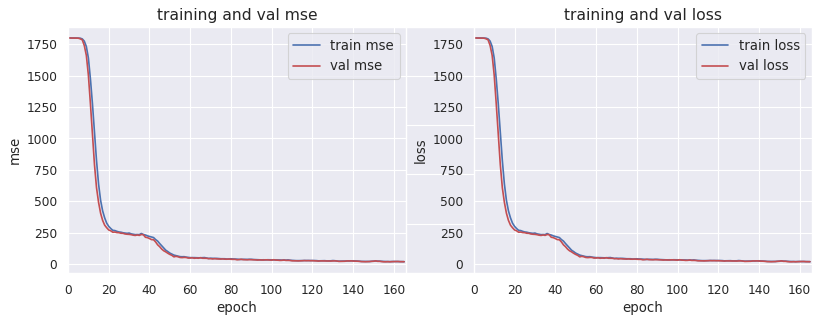

train mse 21.464153
val mse 21.399698


In [26]:

import seaborn as sns

load_flag = 0
if load_flag == 1:
    net=torch.jit.load('model_weight_kalmancnn.pth', map_location="cpu")
    print('load model')
elif load_flag == 0:    
    device2 = torch.device('cpu')

train_mse = []
train_loss = []
val_mse = []
val_loss = []

for i in range(stop_epoch):
    train_mse2 = train_mse_list[i].to(device2)
    train_mse3 = train_mse2.clone().detach().numpy()
    train_mse.append(train_mse3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_mse2 = val_mse_list[i].to(device2)
    val_mse3 = val_mse2.clone().detach().numpy()
    val_mse.append(val_mse3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().detach().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = stop_epoch

fig = plt.subplots(figsize=(12, 4), dpi=80)
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
# plt.tight_layout()


ax1 = plt.subplot(1,2,1,)

plt.xlim(0, num_epochs)
ax1.plot(range(num_epochs), train_mse, c='b', label='train mse')
ax1.plot(range(num_epochs), val_mse, c='r', label='val mse')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('mse', fontsize='12')
ax1.set_title('training and val mse', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
plt.xlim(0, num_epochs)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

print('train mse', train_mse[-1])
print('val mse', val_mse[-1])

In [27]:
# import seaborn as sns
import torch
import torch.nn.functional as F

device2 = torch.device('cpu')

# net=torch.load('model_weight_kalmancnn.pth')
# model = Net()
# model.load_state_dict(torch.load('model_weight.pth'))
#テストデータをpredict
with torch.no_grad():
    test_mse = 0
    test_loss = 0
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)

        test_output = net(data)
        test_loss = criterion(test_output, label)

        mse = torch.mean(torch.square(test_output - label))
        test_mse += mse / len(test_loader)
        test_loss += test_loss / len(test_loader)
        
test_mse2 = test_mse.to(device2)
test_mse3 = test_mse2.clone().detach().numpy()
print('test mse', test_mse3)



test mse 21.126078


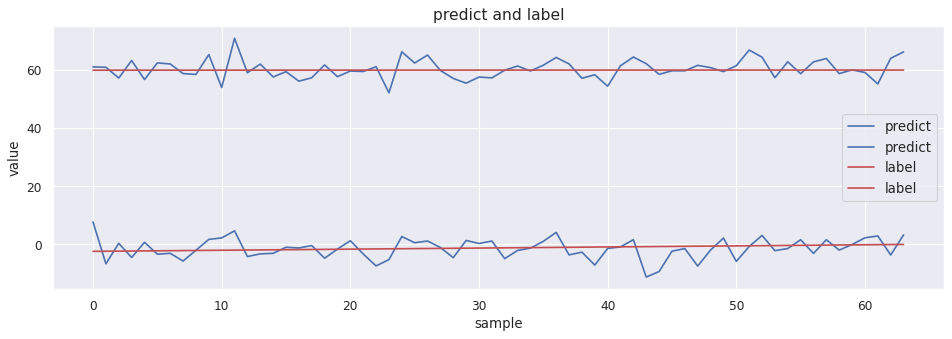

In [28]:
#テストデータの推定値と正解値を縦軸：値、横軸：要素数でプロットする

#テストデータの推定値と正解値を取得する
test_output2 = test_output.to(device2)
test_output3 = test_output2.clone().detach().numpy()
label2 = label.to(device2)
label3 = label2.clone().detach().numpy()

#テストデータの推定値と正解値を一つのグラフにプロットする（subplotsは使わない）
plt.figure(figsize=(12, 4), dpi=80)
plt.tick_params(labelbottom=True, labelleft=True, labelright=False, labeltop=False)
plt.tight_layout()

plt.plot(test_output3, c='b', label='predict')
plt.plot(label3, c='r', label='label')
plt.xlabel('sample', fontsize='12')
plt.ylabel('value', fontsize='12')
plt.title('predict and label', fontsize='14')
plt.legend(fontsize='12')
plt.show()


mse 12.134953


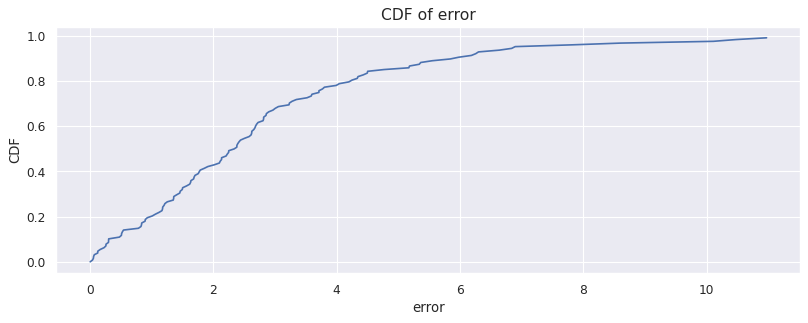

In [29]:
#推定値の絶対誤差を横軸、縦軸をCDFのグラフをプロットする
#推定値の絶対誤差を取得する
test_output4 = test_output3.flatten()
label4 = label3.flatten()
error = np.abs(test_output4 - label4)

mse=np.mean(np.square(test_output4[:]- label4))
print("mse",mse)

#推定値の絶対誤差を昇順に並び替える
error_sorted = np.sort(error)

#CDFを計算する
cdf = np.arange(len(error_sorted))/float(len(error_sorted))

#推定値の絶対誤差とCDFをプロットする
plt.figure(figsize=(12, 4), dpi=80)
plt.tick_params(labelbottom=True, labelleft=True, labelright=False, labeltop=False)
# plt.tight_layout()

plt.plot(error_sorted, cdf)
plt.xlabel('error', fontsize='12')
plt.ylabel('CDF', fontsize='12')
plt.title('CDF of error', fontsize='14')
plt.show()



In [30]:
#テストデータの推定結果にカルマンフィルターを適用して平滑化する。
#カルマンフィルターの実装はpykalmanを使用する
#推定結果の絶対誤差を横軸、縦軸をCDFのグラフをプロットする
import pykalman
# 推移行列などの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=0.000001):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend

    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2

    # 各行列のトレンド成分に対するブロック行列を構築
    G[0,0] = 1
    H[0,0] = 1

    # トレンドモデルの推移行列の構築
    # 非定常過程でも対応できる推移行列を構築
    if n_dim_trend==1:
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1

    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)

    return n_dim_state, F, H, Q
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 3

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs)
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

print("F",F,"\n","H",H,"\n","Q",Q)

# カルマンフィルタのモデル生成
kf = pykalman.KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

print("test_output3 ",test_output3.shape)

#推定結果にカルマンフィルターを適用して平滑化することで新たな推定値を得る
#for文を使って一つのシーケンスずつ適用する
filtered_state_means = []
for i in range(test_output3.shape[1]):
    # iltered_state_means.append(kf.filter([row[i] for row in test_output3])[0])
    # filtered_state_means.append((kf.smooth([row[i] for row in test_output3])[0]))
    # filtered_state_means.append((kf.smooth([row[i] for row in test_output3])[0]).dot(H.T))
    filtered_state_means.append((kf.smooth(test_output3.T[i])[0]).dot(H.T))

filtered_state_means = np.array(filtered_state_means)
print("filtered_state_means shape ",filtered_state_means.shape)

# filtered_state_means=filtered_state_means.reshape(filtered_state_means.shape[1],filtered_state_means.shape[2])
# filtered_state_means=filtered_state_means.reshape(filtered_state_means.shape[1],filtered_state_means.shape[0])
print(test_output3.shape)
print(label3.shape)
print(filtered_state_means.shape)

# ovsevation_means_predicted = filtered_state_means[:,0].dot(observation_covariance.T)
# ovsevation_means_predicted = filtered_state_means[:,1].dot(observation_covariance.T)



F [[ 3. -3.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]] 
 H [[1. 0. 0.]] 
 Q [[1.e-06 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00]]
test_output3  (64, 2)
filtered_state_means shape  (2, 64, 1)
(64, 2)
(64, 2)
(2, 64, 1)


mse 1.668369554014114
(64,)


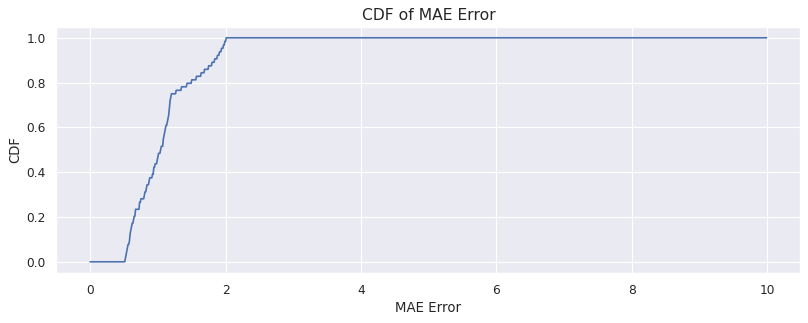

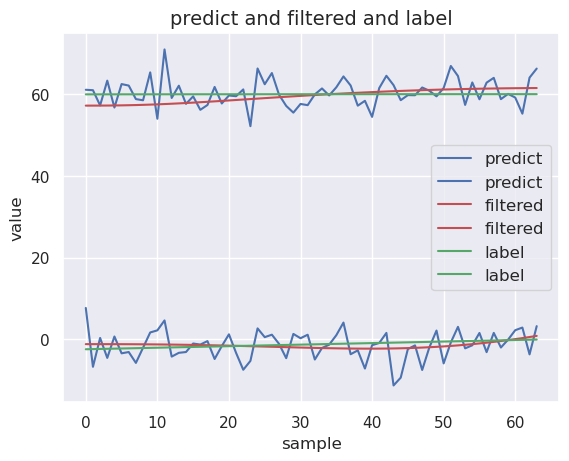

In [31]:
#推定結果の絶対誤差ではなく、MAE Errorを[0:10]として定義したものを横軸とし、縦軸を推定誤差のCDFとする
#推定結果の絶対誤差を計算する
test_output4 = filtered_state_means.squeeze()
label4 = label3.T
error = np.abs(test_output4[:]- label4)
error = error.mean(axis=0)

mse=np.mean(np.square(test_output4[:]- label4))
print("mse",mse)

print(error.shape)
#横軸をMAE Errorを[0:10]として定義する
mae_error = np.arange(0,10,0.01)


#推定誤差のCDFをライブラリを使って計算する
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(error)


#CDFをplotする
plt.figure(figsize=(12, 4), dpi=80)
plt.tick_params(labelbottom=True, labelleft=True, labelright=False, labeltop=False)
# plt.tight_layout()

plt.plot(mae_error, ecdf(mae_error))
plt.xlabel('MAE Error', fontsize='12')
plt.ylabel('CDF', fontsize='12')
plt.title('CDF of MAE Error', fontsize='14')
plt.show()


#推定結果をプロットする
# plt.figure(figsize=(12, 4), dpi=80)
plt.tick_params(labelbottom=True, labelleft=True, labelright=False, labeltop=False)
# plt.tight_layout()

plt.plot(test_output3, c='b', label='predict')
plt.plot(filtered_state_means[0][:][:], c='r', label='filtered')
plt.plot(filtered_state_means[1][:][:], c='r', label='filtered')
plt.plot(label3, c='g', label='label')
plt.xlabel('sample', fontsize='12')
plt.ylabel('value', fontsize='12')
plt.title('predict and filtered and label', fontsize='14')
plt.legend(fontsize='12')
plt.show()
